In [1]:
#make necesarry imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

# Forecasting

In [3]:
df=pd.read_csv("forecasting_data.csv")
df.head()

,Period,Sales
0,1,5384
1,2,8081
2,3,10282
3,4,9156
4,5,6118


# 1.Visualze and interpret the pattern of this time-series

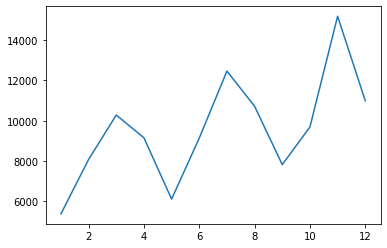

In [7]:
plt.plot(df['Period'], df['Sales'], linestyle='-')
plt.show()

# 2. Predict future demand in the four next quarters without seasonality

### Using moving average

C:\Users\Pavan Adithya Varma\AppData\Local\Temp\ipykernel_11164\798739667.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': i, 'Sales': avg_sales}, ignore_index=True)
C:\Users\Pavan Adithya Varma\AppData\Local\Temp\ipykernel_11164\798739667.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': i, 'Sales': avg_sales}, ignore_index=True)
C:\Users\Pavan Adithya Varma\AppData\Local\Temp\ipykernel_11164\798739667.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  moving_average_df = moving_average_df.append({'Period': i, 'Sales': avg_sales}, ignore_index=True)
C:\Users\Pavan Adithya Varma\AppData\Local\Temp\ipykern

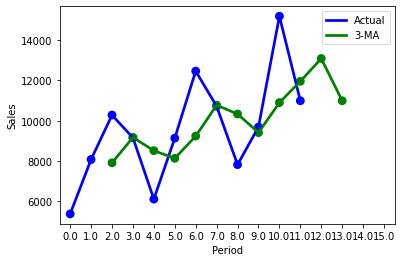

In [25]:
def moving_average(df, k, to_period):
    moving_average_df = pd.DataFrame(columns=['Period', 'Sales'])
    
    # Calculate moving average for each period up to `to_period`
    for i in range(to_period):
        if i < k - 1:
            # Not enough data points to calculate moving average
            avg_sales = float('NaN')
        else:
            # Calculate moving average using a window of size `k`
            avg_sales = df['Sales'].iloc[i - k + 1:i + 1].mean()
        
        # Append the result to the moving_average_df DataFrame
        moving_average_df = moving_average_df.append({'Period': i, 'Sales': avg_sales}, ignore_index=True)
    
    return moving_average_df


# Plotting
f, ax = plt.subplots(1, 1)

# Calculate moving average with window size 3 up to period 16
ma_df = moving_average(df, 3, 16)

# Plot actual sales data
sns.pointplot(x='Period', y='Sales', data=df, color='b', ax=ax)

# Plot moving average
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g', ax=ax)

# Add legend
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "3-MA"])

# Show plot
plt.xlabel('Period')
plt.ylabel('Sales')
plt.show()

### using exponential smoothing

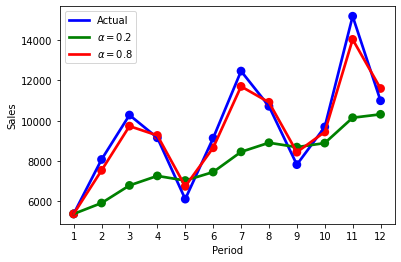

In [20]:
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period', 'Sales'])
    
    # Initialize the first smoothed value with the first actual value
    es_df.loc[0] = df.loc[0]
    
    # Apply exponential smoothing for subsequent periods
    for i in range(1, len(df)):
        smoothed_sales = alpha * df['Sales'].iloc[i] + (1 - alpha) * es_df['Sales'].iloc[i - 1]
        es_df.loc[i] = {'Period': df['Period'].iloc[i], 'Sales': smoothed_sales}
    
    return es_df

# Plotting
f, ax = plt.subplots(1, 1)

# Perform exponential smoothing with different alpha values
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)

# Plot actual sales data
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')

# Plot exponential smoothing results for alpha=0.2 and alpha=0.8
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

# Add legend
ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])

# Show plot
plt.xlabel('Period')
plt.ylabel('Sales')
plt.show()

# 3. Predict future demand in the four next quarters with seasonality

In [36]:
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'

def get_seq(row):
    return (row['Period'] - 1) % 4 + 1  # Calculate sequence number (1 to 4)

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1)
    new_df['Seq'] = new_df.apply(get_seq, axis=1)
    
    season_df = pd.pivot_table(new_df, values='Sales', index='Seq', columns='Season', aggfunc=np.mean)
    
    avg_df = season_df.mean(axis=1)  # Calculate average sales across seasons
    seasonal_index_df = season_df.div(avg_df, axis=0)  # Calculate seasonal indices
    
    # Fit a polynomial to seasonal indices and forecast next period
    season = np.array([1, 2, 3])
    avg_arr = np.array(avg_df.values)
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit)
    average_predict = poly(4)
    
    # Prepare forecasted sales for the specified months
    forecast_sales = average_predict * seasonal_index_df.loc[get_seq({'Period': months[0]})].values[0]
    forecast_df = pd.DataFrame({'Period': months, 'Sales': forecast_sales})
    
    return forecast_df

# Generate forecast for the specified months
season_df = predict_with_seasonality(df, [13, 14, 15, 16])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Period'], df['Sales'], c='y', label='Actual Sales')
plt.plot(season_df['Period'], season_df['Sales'], c='r', label='Forecasted Sales')
plt.title('Actual vs. Forecasted Sales with Seasonality')
plt.xlabel('Period')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

TypeError: expected x and y to have same length